[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dominik-strutz/moon_oed/blob/main/00_b_freq2vel.ipynb)

In [1]:
# MAKE SURE TO RUN THIS CELL FIRST
# this might take a minute or two
# This cell will install the necessary dependencies and import the necessary modules for the notebook to run in Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False
    
if IN_COLAB:
    dependencies_installed = False

    if not dependencies_installed:
        ! rm -rf *
        ! git clone --quiet https://github.com/dominik-strutz/moon_oed tmp
        ! mv tmp/* .
        ! rm -rf tmp
        # only install the first 8 lines of the requirements file to only install the necessary dependencies
        # ! head -5 requirements.txt > tmp.txt
        # ! mv tmp.txt requirements.txt 
        # ! pip install -q -r requirements.txt
        dependencies_installed = True
    from google.colab import output
    output.enable_custom_widget_manager()

In [2]:
import numpy as np
import torch
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('https://raw.githubusercontent.com/dominik-strutz/dotfiles/main/mystyle.mplstyle')

In [3]:
kernel_df = pd.read_csv('data/sensitivity_kernels/sensitivity_kernels.csv')
freqs = kernel_df.keys()

In [4]:
velocity_model = pd.read_csv('data/velocity_model_no_ice.csv')
depths = torch.tensor(velocity_model['depth'].values)
vp_model = torch.tensor(velocity_model['vp'].values)
vs_model = torch.tensor(velocity_model['vs'].values)

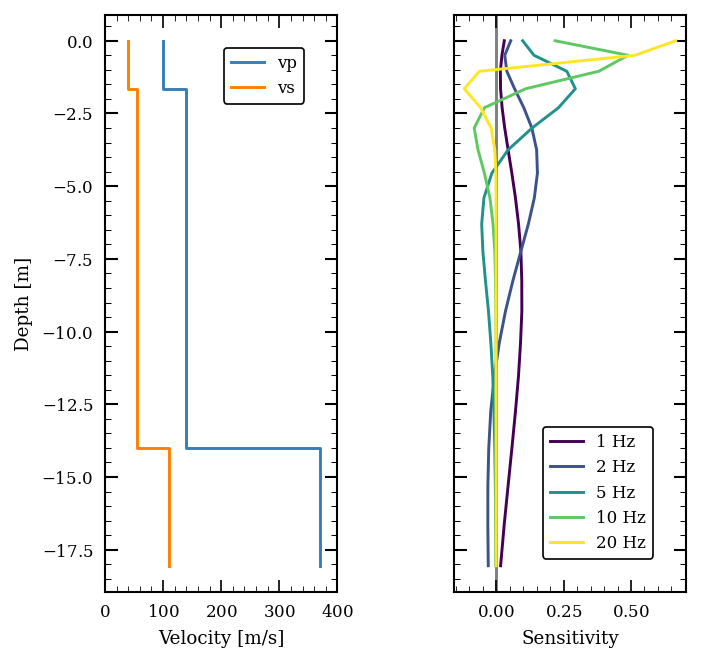

In [5]:
fig, ax = plt.subplots(
    1, 2, figsize=(5, 5),
    gridspec_kw={'wspace': 0.5}, sharey=True)

# plot step model using appropriate mpl function
ax[0].step(vp_model, depths, label='vp', where='post')
ax[0].step(vs_model, depths, label='vs', where='post')

kernel_colors = plt.cm.viridis(np.linspace(0, 1, len(freqs)))
for i, f in enumerate(freqs):
    ax[1].plot(kernel_df[f], depths, label=f'{f} Hz', color=kernel_colors[i])
    
ax[0].set_xlabel('Velocity [m/s]')
ax[0].set_xlim(0, 400)
ax[0].set_ylabel('Depth [m]')

ax[1].set_xlabel('Sensitivity')
ax[1].axvline(0, color='gray', linestyle='-', zorder=0)

ax[0].legend()
ax[1].legend()

plt.show()


In [6]:
class Freq2Vel:
    def __init__(self, kernel_df):
        self.frequencies = kernel_df.keys()
        self.kernel_df = kernel_df
        
    def __call__(self, velocity, freq):
        if freq not in self.frequencies:
            raise ValueError(f'Frequency {freq} not in {self.frequencies}')
        
        kernel = torch.tensor(self.kernel_df[freq]) 
        return torch.dot(kernel, velocity)

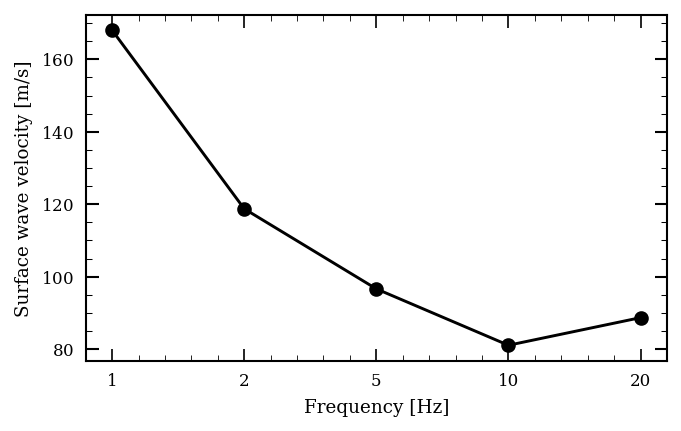

In [7]:
freq2vel = Freq2Vel(kernel_df)

average_velocities = [freq2vel(vp_model, f) for f in freqs]

fig, ax = plt.subplots(figsize=(5, 3))

ax.plot(
    freqs, average_velocities,
    marker='o', color='black', zorder=2)       

ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Surface wave velocity [m/s]')

plt.show()